## Generate dynamics dataset

In [1]:
!python ../src/generate_data.py ../data/train
!python ../src/generate_data.py -n 500 --random_seed 10 ../data/test

Failed to build trajectory for index 108, retrying
Failed to build trajectory for index 1826, retrying
Failed to build trajectory for index 2136, retrying
Failed to build trajectory for index 4886, retrying
Failed to build trajectory for index 5673, retrying
Failed to build trajectory for index 8681, retrying
Failed to build trajectory for index 9674, retrying


## dev

In [1]:
import matplotlib.pyplot as plt
import os

os.chdir("../src/")

from environment import Environment
from random_env import get_random_env

In [3]:
scale = 4
env, _, _ = get_random_env(scale)

[(4, -4), (3, -5), (-4, -3), (-5, -4), (-6, -2), (-2, 0), (-2, 0), (-7, 0), (-5, -2), (-7, 1)]


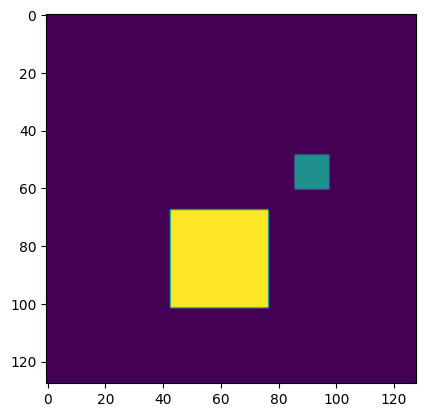

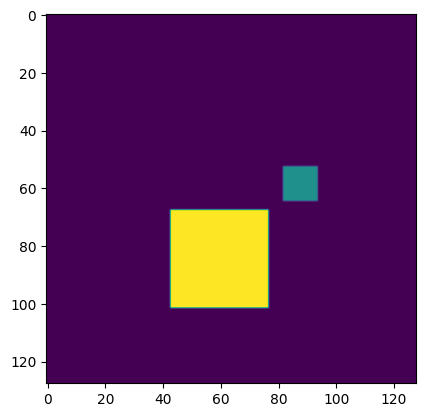

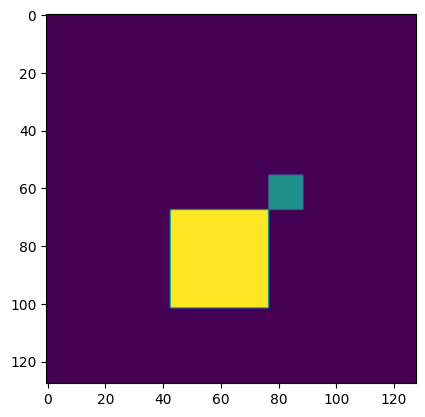

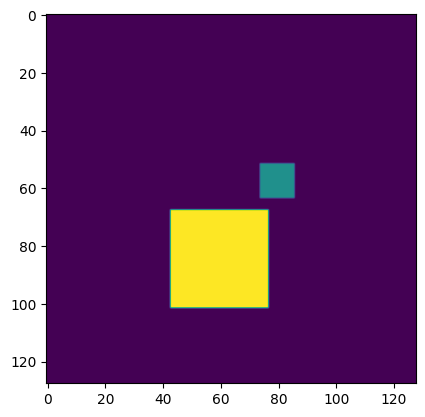

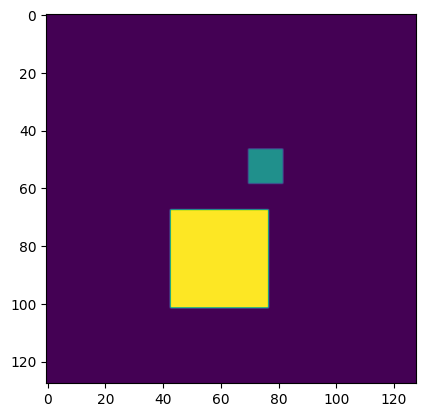

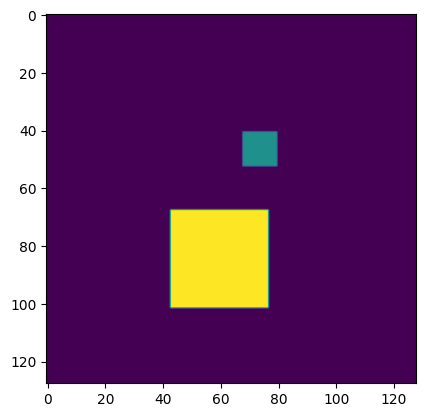

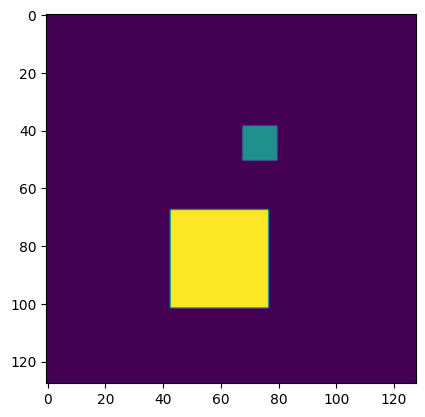

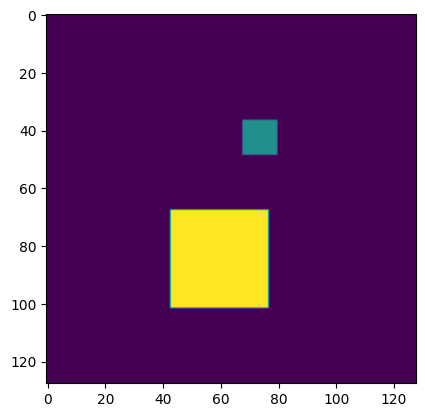

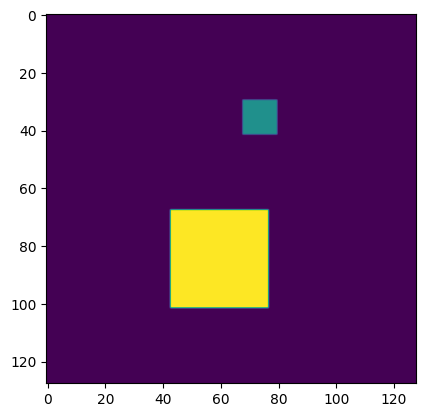

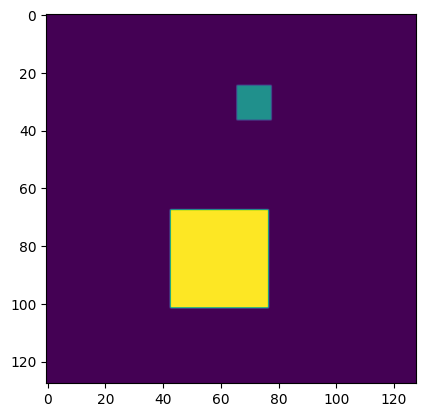

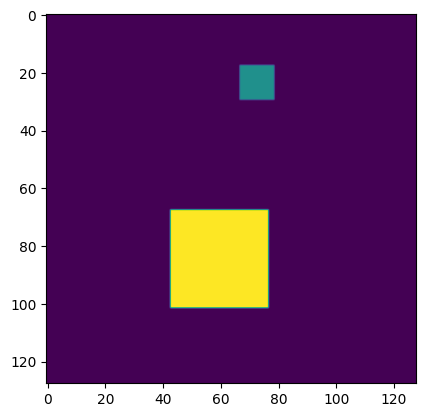

In [4]:
states, actions = env.generate_trajectory(10, max_step=scale * 2)
print(actions)
for state in states:
    plt.imshow(env.plot_enviroment(state))
    plt.show()

### Dataset

In [11]:
!python ../src/generate_data.py -n 1 ../data/dev

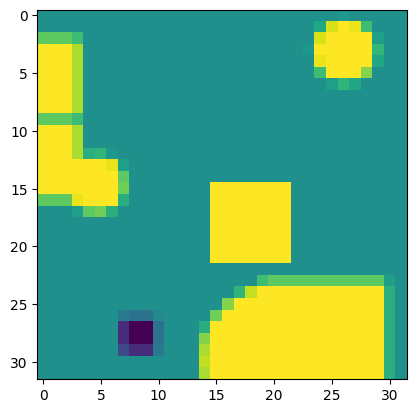

In [27]:
from dataset_image import LSBMPDataset

dataset = LSBMPDataset("../data/dev")
plt.imshow(dataset[0][0])
plt.show()

In [6]:
import pandas as pd

In [8]:
df = pd.read_csv("geometric_data.csv")
df

,2.0,4.0,5.0,5.0.1,6.0,6.0.1,7.0,7.0.1,8.0,8.0.1,...,50.0.94,50.0.95,49.0.53,48.0.77,47.0.53,46.0.44,4.0.14,2.0.5,-0.1331538773661444,-0.038732802222191505
0,2.0,4.0,5.0,5.0,6.0,6.0,7.0,7.0,8.0,8.0,...,50.0,50.0,49.0,48.0,47.0,46.0,4.0,2.0,0.091638,-0.055993
1,2.0,4.0,5.0,5.0,6.0,6.0,38.0,50.0,62.0,63.0,...,40.0,50.0,49.0,48.0,47.0,46.0,45.0,44.0,-0.013827,-0.023591
2,2.0,4.0,5.0,5.0,6.0,6.0,38.0,50.0,62.0,63.0,...,40.0,50.0,49.0,48.0,47.0,46.0,45.0,44.0,-0.023065,-0.077096
3,2.0,4.0,5.0,5.0,6.0,6.0,38.0,50.0,62.0,63.0,...,40.0,50.0,49.0,48.0,47.0,46.0,45.0,44.0,0.134355,-0.062330
4,2.0,4.0,5.0,5.0,6.0,6.0,38.0,50.0,62.0,63.0,...,40.0,50.0,49.0,48.0,47.0,46.0,45.0,44.0,0.147079,-0.077733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,2.0,4.0,5.0,47.0,48.0,51.0,60.0,61.0,62.0,63.0,...,7.0,7.0,6.0,6.0,5.0,5.0,4.0,2.0,-0.131208,-0.148243
4995,2.0,4.0,5.0,47.0,48.0,51.0,60.0,61.0,62.0,63.0,...,7.0,7.0,6.0,6.0,5.0,5.0,4.0,2.0,0.046536,0.023246
4996,2.0,4.0,5.0,47.0,48.0,51.0,60.0,61.0,62.0,63.0,...,7.0,7.0,6.0,6.0,5.0,5.0,4.0,2.0,0.130284,-0.087056
4997,2.0,4.0,5.0,5.0,6.0,6.0,7.0,7.0,8.0,8.0,...,7.0,7.0,6.0,6.0,5.0,5.0,4.0,2.0,-0.084051,-0.094022


In [9]:
32 * 32 * 3 + 2

3074